Testing tons of models it looks like none is learning anything but restnet50 without DataAugmentation => https://github.com/albertovpd/viu_tfm-deep_vision_classification/blob/3folders_08trainds/src/tfm_2022_02_05.ipynb

What's wrong with nns or input pictures? Let's take a valid resnet50, the input dataset, and generate shuffled folders with uneven partitions of the input dataset. Let's discover if this resnet50 have similar curves than the one trained with 80% of input dataset, or if there's something wrong with data.

In [1]:
# Google Drive stuff
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Feb 10 15:44:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# tf
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


- libs

In [4]:
%tensorflow_version 2.x
# batch ingestion of pics without pickle
from tensorflow.keras.preprocessing import image_dataset_from_directory

# nns
from tensorflow.keras.applications import ResNet50 

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers 

# optimization
from tensorflow.keras.optimizers import SGD #Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping

# metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from sklearn.metrics import plot_precision_recall_curve
from itertools import chain # to flatten the real labels array from validation set
import json # to save in a file metrics
#from datetime import datetime # to name results

# viz & arrays
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# navigating through folder
import os

- paths

In [5]:
# paths i'll use
base_folder = "/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/"

# folder with 0.8 in split for training set, 0.15 for test and 0.05 for val
folder = "folds_validation/"
input = base_folder+"input/"+folder
src_folder =  base_folder+"src/"
output_folder = base_folder + "/output/"

- functions

In [6]:
def generic_last_2layers(data_augmentation, nn,neurons_final_layer:int,  dropout_layers: bool, dropout_position: str =="first", dropout_percent: float):
  '''
  Xception, InceptionResNetV2, DenseNet121 have different architecture, but all of them have the same top model. So we add the data augmentation layer,
  load the functional model and add the top model with/without dropout in first/middle position
  works with pre-trained models (Xception, InceptionResNetV2, DenseNet121) for transfer-learning. 
  top layer consisting of 2 layers: globalaverage2d layer and predictions layer.
  - nn                  = pre-trained model without top model
  - neurons_final_layer = how many classes we want to work with
  - dropout_layers      = bool. dropout in the top model (True/False)
  - dropout_position    = dropout layer before top model or between dense layers (first/middle)
  - dropout_percent     = (0,1). float
  EX: generic_last_2layers(Xception(include_top=False, 
                                    weights='imagenet', 
                                    input_shape=(128, 128, 3), 
                                    classes = num_classes, 
                                    classifier_activation='softmax'
                                    ), 
                          5, True, "first", 0.2
                          )
  '''
  pre_trained = Sequential()

  if data_augmentation:
    #data augmentation
    pre_trained.add(data_augmentation)
    pre_trained.add(layers.Rescaling(1./255))

  pre_trained.add(nn)

  # Freeze the layers 
  for layer in pre_trained.layers:
      layer.trainable = False

  #adding top model with/without dropout
  if dropout_layers is True:
      if dropout_position=="first":
          pre_trained.add(layers.Dropout(dropout_percent)) 
          pre_trained.add(layers.GlobalAveragePooling2D()) # https://keras.io/api/layers/pooling_layers/global_average_pooling2d/
          

      elif dropout_position == "middle":
          pre_trained.add(layers.GlobalAveragePooling2D()) 
          pre_trained.add(layers.Dropout(dropout_percent)) 
      
  else:
    pre_trained.add(layers.GlobalAveragePooling2D())
  
  # last layer
  pre_trained.add(layers.Dense(neurons_final_layer,activation=('softmax')))
  return pre_trained


def plotting_model(model, epochs, name, location):
  '''
  Plotting the training and validation loss and accuracy
  :model: nn
  :epochs
  :name: name to save the final image
  :location: path to save the image
  '''

  f,ax=plt.subplots(2, 1, figsize=(15,10))
  #Loss
  ax[0].plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
  ax[0].plot(np.arange(0, epochs), history.history["val_loss"], label="test_loss")
  ax[0].grid(visible=True, which="both", axis='both')
  ax[0].legend()

  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  #Accuracy
  ax[1].plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
  ax[1].plot(np.arange(0, epochs), history.history["val_accuracy"], label="test_acc")
  ax[1].grid(visible=True, which="both", axis='both')
  ax[1].legend()

  plt.xlabel("Run Epochs: "+str(epochs)+" ||    "+name)
  plt.ylabel("Loss/Accuracy")
  
  plt.savefig(location)
  plt.show()
  

def model_evaluation(evaluation, output_folder:str, name:str):
  '''
  evaluation the model with test_ds
  :evaluation: model.evaluate(val_dataset, batch_size, return_dict=True)
  :output_folder: path to save the json
  :name: name of the file
  '''
  models_metrics = {}  
  models_metrics[name] = evaluation
  # saving the metris in json file
  with open(output_folder+name+"-metrics.json", "w") as outfile:
    json.dump(models_metrics, outfile)
  return models_metrics

def classification_report_pic(y_pred, y_target, class_names, output_folder, name):
  '''
  prints inline the classification report and also saves a pic with results
  - y_pred = inferences: n.argmax( model.predict(test_ds), axis=1)
  - validation_ds = the test dataset (if you have 3 folders)
  - class_names
  - output_folder: the path to save the pic
  - name
  '''  
  print(classification_report(y_pred , y_target, target_names=class_names))

  
  clf_report = classification_report(y_pred , y_target, target_names=class_names, output_dict=True )
  # .iloc[:-1, :] to exclude support
  plt.figure(figsize = (10,8))
  plt.title("classification report: "+name)
  sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
  plt.savefig(output_folder+name+"-classification_report.png")
  plt.show()

def confusion_matrix_report(y_pred, y_target,  class_names, output_folder, name):
  '''
  displays inline a pic and also saves it
  - y_pred: inferences
  - y_target: labels
  - class_names
  - output_folder: path to save pic
  - name
  '''
  
  cm = confusion_matrix(y_target, y_pred, normalize="true" ) #,  labels=[class_names])
  df_cm = pd.DataFrame(cm, index= [class_names], columns = [class_names])
  fig = plt.figure(figsize = (10,8))
  ax1 = fig.add_subplot(1,1,1)
  sns.set(font_scale=1.4) #for label size
  sns.heatmap(df_cm, annot=True, annot_kws={"size": 12})
  plt.title("confusion matrix: "+name)
  ax1.set_ylabel('True Values',fontsize=14)
  ax1.set_xlabel('Predicted Values',fontsize=14)
  plt.savefig(output_folder+name+"-confusion_matrix.png")
  plt.show()

- at first, there were 606 pics for bathroom, 1248 for bedroom, 1158 for dinning, 965 for kitchen, 1273 for living room.

For each class, let's take a random percentaje of it and apply to the rest of classes. That are the folders printed below:

0.5 from bedroom, 33% of 606 from bathroom, 46% of 1248 from dinning, 62% of 965 from kitchen, 79% of 1273 for living room
['Bedroom', 'Bathroom', 'Dinning', 'Livingroom', 'Kitchen']

In [7]:
input

'/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/folds_validation/'

In [8]:
os.listdir(input)

['fold079', 'fold05', 'fold062', 'fold046', 'fold033']

In [9]:
total = 0
for root, dirs, files in os.walk(input):
    total += len(files)
    print(dirs, len(files))

['fold079', 'fold05', 'fold062', 'fold046', 'fold033'] 0
['test_ds', 'train_ds'] 0
['Bathroom', 'Bedroom', 'Livingroom', 'Kitchen', 'Dinning'] 0
[] 96
[] 197
[] 201
[] 153
[] 183
['Dinning', 'Bathroom', 'Bedroom', 'Kitchen', 'Livingroom'] 0
[] 731
[] 382
[] 788
[] 609
[] 804
['train_ds', 'test_ds'] 0
['Bedroom', 'Livingroom', 'Bathroom', 'Dinning', 'Kitchen'] 0
[] 499
[] 518
[] 242
[] 463
[] 385
['Dinning', 'Bathroom', 'Kitchen', 'Bedroom', 'Livingroom'] 0
[] 116
[] 61
[] 97
[] 125
[] 128
['test_ds', 'train_ds'] 0
['Livingroom', 'Bedroom', 'Kitchen', 'Bathroom', 'Dinning'] 0
[] 158
[] 155
[] 120
[] 75
[] 144
['Dinning', 'Bedroom', 'Kitchen', 'Livingroom', 'Bathroom'] 0
[] 573
[] 618
[] 478
[] 631
[] 300
['train_ds', 'test_ds'] 0
['Livingroom', 'Bathroom', 'Bedroom', 'Dinning', 'Kitchen'] 0
[] 468
[] 222
[] 459
[] 425
[] 354
['Kitchen', 'Dinning', 'Livingroom', 'Bedroom', 'Bathroom'] 0
[] 89
[] 107
[] 117
[] 115
[] 56
['train_ds', 'test_ds'] 0
['Bedroom', 'Bathroom', 'Dinning', 'Livingr

- start validation

In [10]:
image_size = (128,128)
batch_size = 128
epochs = 150
opt = SGD(momentum=0.9) 

In [11]:
base_model_resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = 5) 
models_dict = {"resnet50_NOdataAug_dropoutFirst007": 
         generic_last_2layers(data_augmentation= None, nn=base_model_resnet50, neurons_final_layer=5, dropout_layers=True,  dropout_position="first",  dropout_percent = 0.07)
         }


 FOLDER :  fold079
train dataset
Found 3314 files belonging to 5 classes.

 test dataset
Found 830 files belonging to 5 classes.
['Bedroom', 'Bathroom', 'Dinning', 'Livingroom', 'Kitchen']
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/folds_validation/fold079/train_ds/  =>  train_ds/ 0
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/folds_validation/fold079/train_ds/Dinning  =>  train_ds/ 731
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/folds_validation/fold079/train_ds/Bathroom  =>  train_ds/ 382
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/folds_validation/fold079/train_ds/Bedroom  =>  train_ds/ 788
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/folds_validation/fold079/train_ds/Kitchen  =>  train_ds/ 609
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/folds_validation/fold079/train_ds/Livingroom  =>  train_ds/ 804
/content/drive/My Drive

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


26/26 [==============================] - 23s 531ms/step - loss: 68.2143 - accuracy: 0.3947 - val_loss: 243.7420 - val_accuracy: 0.2422
Epoch 2/150
26/26 [==============================] - 8s 293ms/step - loss: 362.1441 - accuracy: 0.0103 - val_loss: 217.5764 - val_accuracy: 0.2265
Epoch 3/150
26/26 [==============================] - 7s 280ms/step - loss: 211.3934 - accuracy: 0.0652 - val_loss: 91.7076 - val_accuracy: 0.3783
Epoch 4/150
26/26 [==============================] - 7s 279ms/step - loss: 248.0488 - accuracy: 0.1113 - val_loss: 108.9091 - val_accuracy: 0.4096
Epoch 5/150
26/26 [==============================] - 7s 281ms/step - loss: 137.9346 - accuracy: 0.2209 - val_loss: 65.7214 - val_accuracy: 0.4277
Epoch 6/150
26/26 [==============================] - 7s 283ms/step - loss: 173.8888 - accuracy: 0.1454 - val_loss: 78.1802 - val_accuracy: 0.4048
Epoch 7/150
26/26 [==============================] - 7s 280ms/step - loss: 168.5319 - accuracy: 0.1771 - val_loss: 70.5791 - val_accu

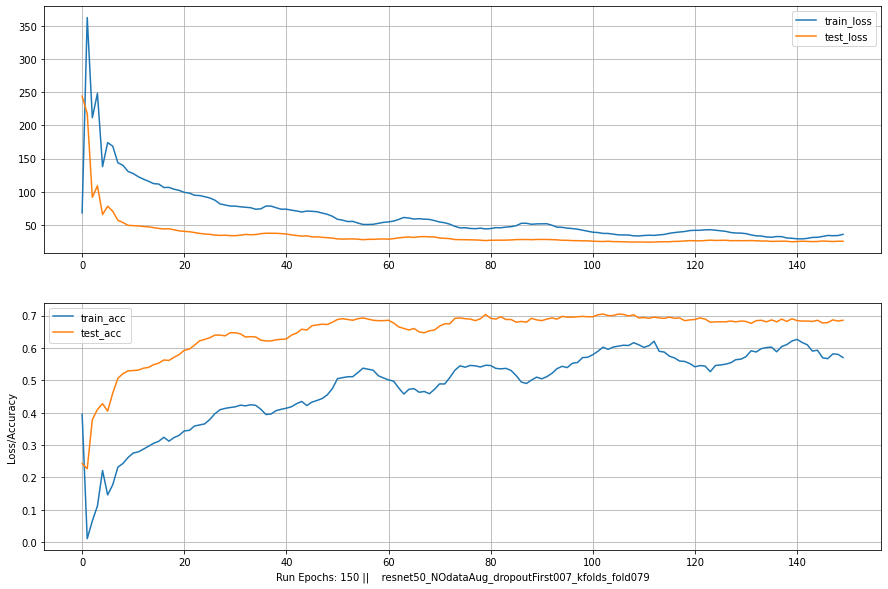

7/7 [==============================] - 2s 210ms/step - loss: 25.5568 - accuracy: 0.6855
              precision    recall  f1-score   support

     Bedroom       0.70      0.82      0.75       168
    Bathroom       0.69      0.80      0.74        82
     Dinning       0.59      0.75      0.66       144
  Livingroom       0.61      0.63      0.62       193
     Kitchen       0.89      0.56      0.69       243

    accuracy                           0.69       830
   macro avg       0.69      0.71      0.69       830
weighted avg       0.71      0.69      0.68       830



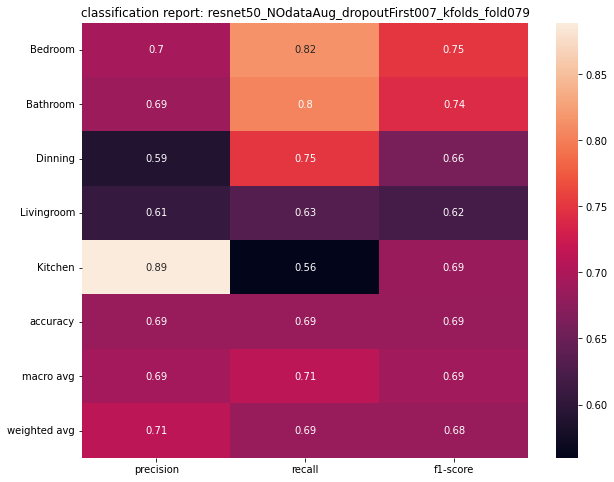

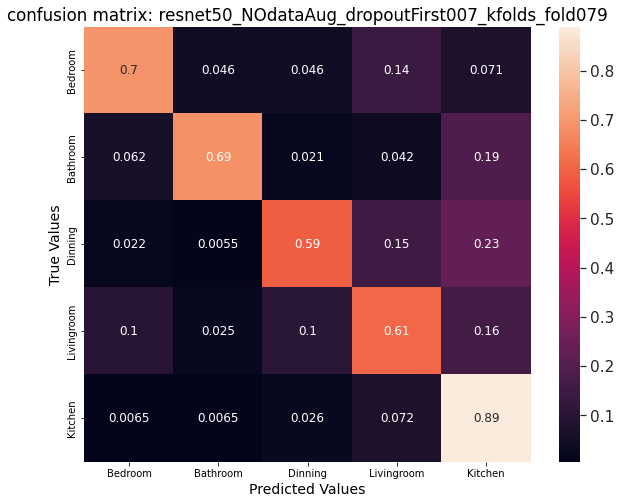


 FOLDER :  fold05
train dataset
Found 2107 files belonging to 5 classes.

 test dataset
Found 527 files belonging to 5 classes.
['Bedroom', 'Bathroom', 'Dinning', 'Livingroom', 'Kitchen']
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/folds_validation/fold05/train_ds/  =>  train_ds/ 0
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/folds_validation/fold05/train_ds/Bedroom  =>  train_ds/ 499
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/folds_validation/fold05/train_ds/Livingroom  =>  train_ds/ 518
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/folds_validation/fold05/train_ds/Bathroom  =>  train_ds/ 242
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/folds_validation/fold05/train_ds/Dinning  =>  train_ds/ 463
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/folds_validation/fold05/train_ds/Kitchen  =>  train_ds/ 385
/content/drive/My Drive/2-Estu

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


17/17 [==============================] - 464s 28s/step - loss: 37.3087 - accuracy: 0.6009 - val_loss: 16.3859 - val_accuracy: 0.7457
Epoch 2/150
17/17 [==============================] - 5s 283ms/step - loss: 15.4874 - accuracy: 0.7689 - val_loss: 14.3810 - val_accuracy: 0.7799
Epoch 3/150
17/17 [==============================] - 5s 279ms/step - loss: 19.2883 - accuracy: 0.7304 - val_loss: 13.5849 - val_accuracy: 0.7932
Epoch 4/150
17/17 [==============================] - 5s 276ms/step - loss: 16.6699 - accuracy: 0.7565 - val_loss: 13.6607 - val_accuracy: 0.7856
Epoch 5/150
17/17 [==============================] - 5s 281ms/step - loss: 16.5254 - accuracy: 0.7489 - val_loss: 13.2918 - val_accuracy: 0.7818
Epoch 6/150
17/17 [==============================] - 5s 278ms/step - loss: 16.1946 - accuracy: 0.7584 - val_loss: 13.5239 - val_accuracy: 0.7780
Epoch 7/150
17/17 [==============================] - 5s 279ms/step - loss: 15.5555 - accuracy: 0.7532 - val_loss: 13.0300 - val_accuracy: 0.79

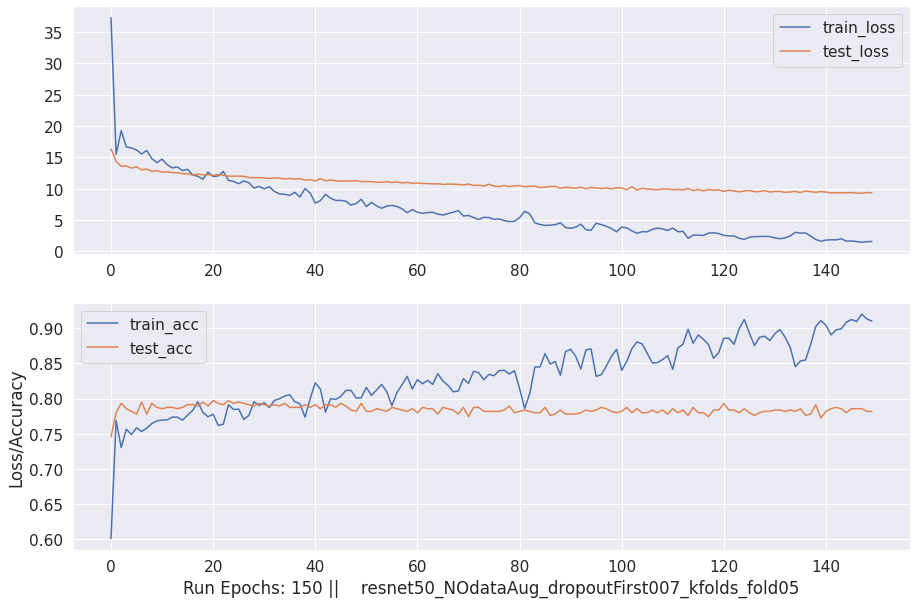

5/5 [==============================] - 1s 184ms/step - loss: 9.3325 - accuracy: 0.7818
              precision    recall  f1-score   support

     Bedroom       0.80      0.81      0.81       123
    Bathroom       0.66      0.77      0.71        52
     Dinning       0.79      0.84      0.81       110
  Livingroom       0.74      0.74      0.74       128
     Kitchen       0.88      0.75      0.81       114

    accuracy                           0.78       527
   macro avg       0.77      0.78      0.78       527
weighted avg       0.79      0.78      0.78       527



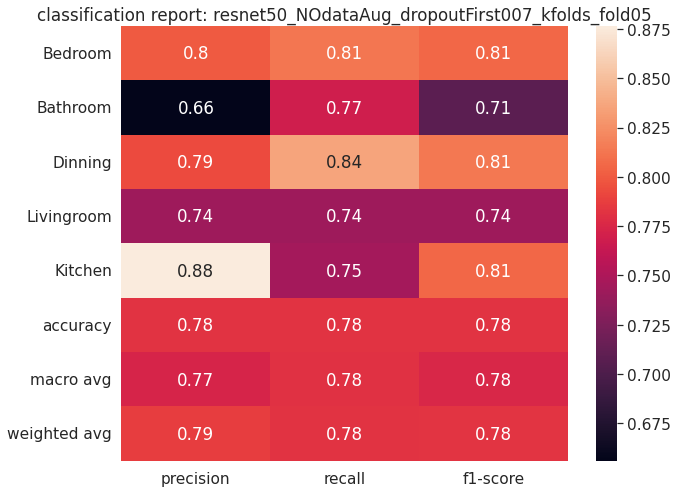

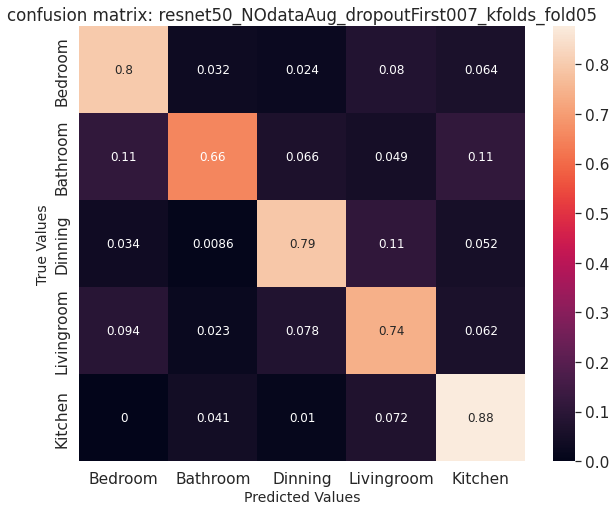


 FOLDER :  fold062
train dataset
Found 2600 files belonging to 5 classes.

 test dataset
Found 652 files belonging to 5 classes.
['Bedroom', 'Bathroom', 'Dinning', 'Livingroom', 'Kitchen']
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/folds_validation/fold062/train_ds/  =>  train_ds/ 0
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/folds_validation/fold062/train_ds/Dinning  =>  train_ds/ 573
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/folds_validation/fold062/train_ds/Bedroom  =>  train_ds/ 618
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/folds_validation/fold062/train_ds/Kitchen  =>  train_ds/ 478
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/folds_validation/fold062/train_ds/Livingroom  =>  train_ds/ 631
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/folds_validation/fold062/train_ds/Bathroom  =>  train_ds/ 300
/content/drive/My Drive

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


21/21 [==============================] - 536s 26s/step - loss: 9.9888 - accuracy: 0.7735 - val_loss: 11.0755 - val_accuracy: 0.7515
Epoch 2/150
21/21 [==============================] - 6s 279ms/step - loss: 32.2293 - accuracy: 0.4923 - val_loss: 16.1958 - val_accuracy: 0.6840
Epoch 3/150
21/21 [==============================] - 6s 282ms/step - loss: 73.4272 - accuracy: 0.2996 - val_loss: 18.2014 - val_accuracy: 0.6564
Epoch 4/150
21/21 [==============================] - 6s 276ms/step - loss: 82.1889 - accuracy: 0.2850 - val_loss: 19.2515 - val_accuracy: 0.6564
Epoch 5/150
21/21 [==============================] - 6s 279ms/step - loss: 63.6269 - accuracy: 0.3496 - val_loss: 13.0296 - val_accuracy: 0.7607
Epoch 6/150
21/21 [==============================] - 6s 277ms/step - loss: 57.4209 - accuracy: 0.4004 - val_loss: 9.8326 - val_accuracy: 0.8144
Epoch 7/150
21/21 [==============================] - 6s 279ms/step - loss: 48.6096 - accuracy: 0.4681 - val_loss: 9.3823 - val_accuracy: 0.8344


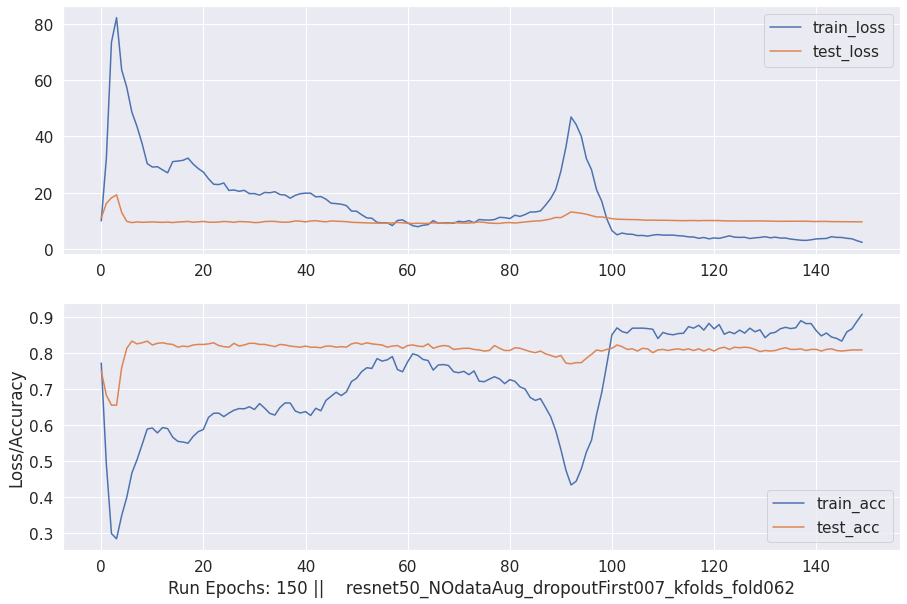

6/6 [==============================] - 1s 196ms/step - loss: 9.6567 - accuracy: 0.8098
              precision    recall  f1-score   support

     Bedroom       0.84      0.85      0.84       153
    Bathroom       0.83      0.84      0.83        74
     Dinning       0.78      0.80      0.79       140
  Livingroom       0.77      0.77      0.77       158
     Kitchen       0.86      0.81      0.83       127

    accuracy                           0.81       652
   macro avg       0.81      0.81      0.81       652
weighted avg       0.81      0.81      0.81       652



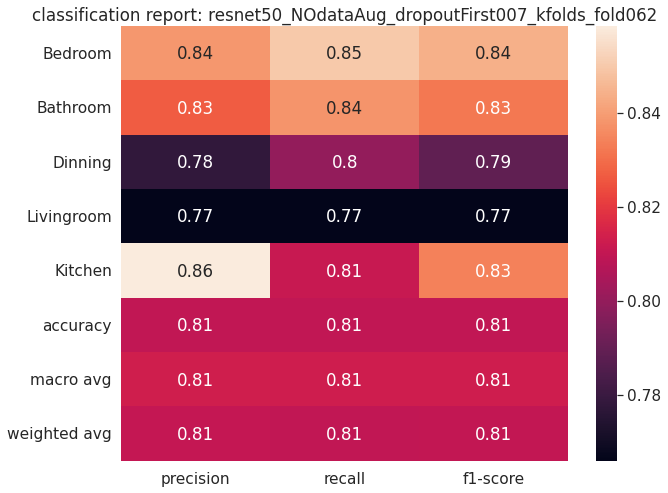

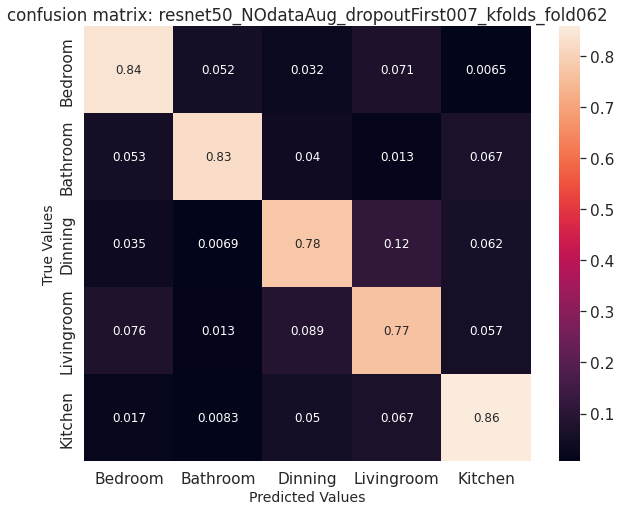


 FOLDER :  fold046
train dataset
Found 1928 files belonging to 5 classes.

 test dataset
Found 484 files belonging to 5 classes.
['Bedroom', 'Bathroom', 'Dinning', 'Livingroom', 'Kitchen']
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/folds_validation/fold046/train_ds/  =>  train_ds/ 0
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/folds_validation/fold046/train_ds/Livingroom  =>  train_ds/ 468
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/folds_validation/fold046/train_ds/Bathroom  =>  train_ds/ 222
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/folds_validation/fold046/train_ds/Bedroom  =>  train_ds/ 459
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/folds_validation/fold046/train_ds/Dinning  =>  train_ds/ 425
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/folds_validation/fold046/train_ds/Kitchen  =>  train_ds/ 354
/content/drive/My Drive

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


16/16 [==============================] - 404s 25s/step - loss: 8.2980 - accuracy: 0.7998 - val_loss: 6.2212 - val_accuracy: 0.8678
Epoch 2/150
16/16 [==============================] - 4s 277ms/step - loss: 9.7073 - accuracy: 0.7635 - val_loss: 6.1046 - val_accuracy: 0.8719
Epoch 3/150
16/16 [==============================] - 4s 278ms/step - loss: 7.6577 - accuracy: 0.8164 - val_loss: 6.4645 - val_accuracy: 0.8678
Epoch 4/150
16/16 [==============================] - 4s 276ms/step - loss: 7.8496 - accuracy: 0.8076 - val_loss: 6.1859 - val_accuracy: 0.8719
Epoch 5/150
16/16 [==============================] - 4s 277ms/step - loss: 8.3119 - accuracy: 0.7967 - val_loss: 6.1484 - val_accuracy: 0.8678
Epoch 6/150
16/16 [==============================] - 4s 277ms/step - loss: 7.3674 - accuracy: 0.8200 - val_loss: 6.0951 - val_accuracy: 0.8740
Epoch 7/150
16/16 [==============================] - 4s 276ms/step - loss: 6.9205 - accuracy: 0.8242 - val_loss: 5.9495 - val_accuracy: 0.8719
Epoch 8/150

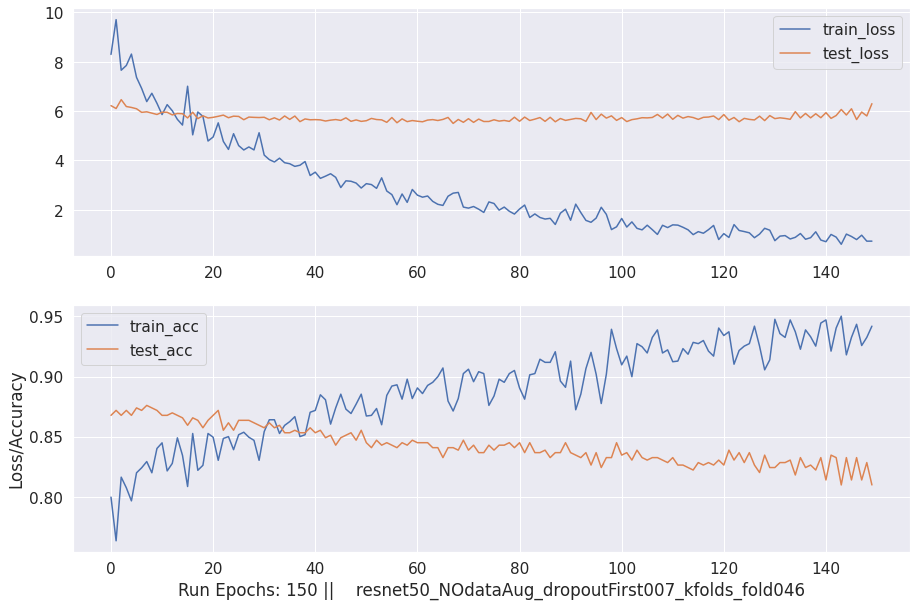

4/4 [==============================] - 1s 233ms/step - loss: 6.3012 - accuracy: 0.8099
              precision    recall  f1-score   support

     Bedroom       0.88      0.83      0.86       121
    Bathroom       0.89      0.86      0.88        58
     Dinning       0.72      0.86      0.78        90
  Livingroom       0.74      0.80      0.77       107
     Kitchen       0.88      0.72      0.79       108

    accuracy                           0.81       484
   macro avg       0.82      0.82      0.81       484
weighted avg       0.82      0.81      0.81       484



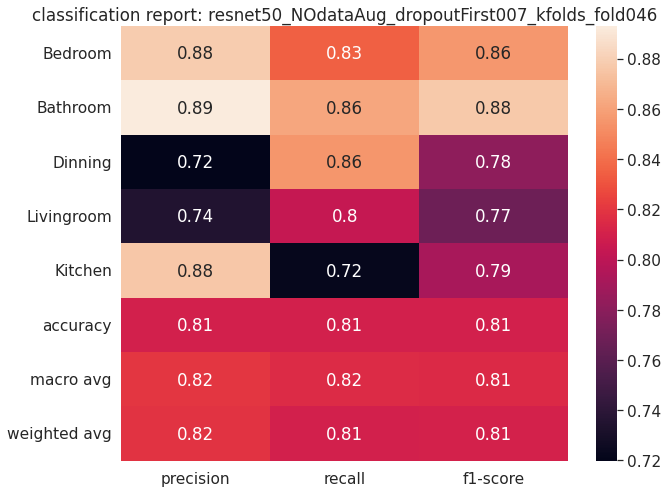

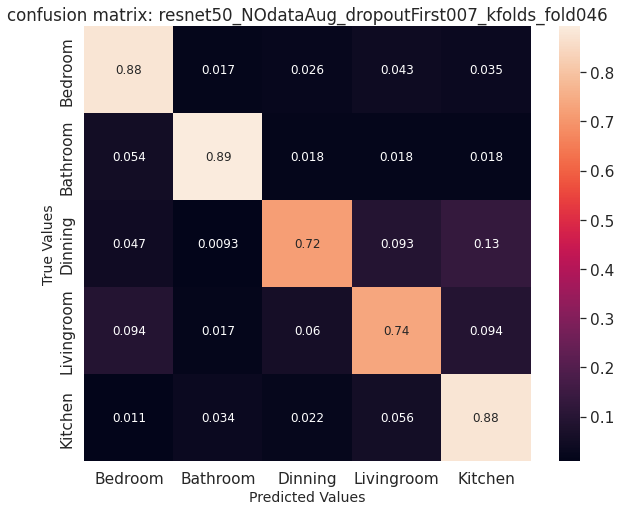


 FOLDER :  fold033
train dataset
Found 1382 files belonging to 5 classes.

 test dataset
Found 348 files belonging to 5 classes.
['Bedroom', 'Bathroom', 'Dinning', 'Livingroom', 'Kitchen']
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/folds_validation/fold033/train_ds/  =>  train_ds/ 0
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/folds_validation/fold033/train_ds/Bedroom  =>  train_ds/ 328
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/folds_validation/fold033/train_ds/Bathroom  =>  train_ds/ 159
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/folds_validation/fold033/train_ds/Dinning  =>  train_ds/ 305
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/folds_validation/fold033/train_ds/Livingroom  =>  train_ds/ 336
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/folds_validation/fold033/train_ds/Kitchen  =>  train_ds/ 254
/content/drive/My Drive

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


11/11 [==============================] - 279s 26s/step - loss: 5.6219 - accuracy: 0.8336 - val_loss: 3.7102 - val_accuracy: 0.8793
Epoch 2/150
11/11 [==============================] - 3s 303ms/step - loss: 5.9290 - accuracy: 0.8191 - val_loss: 3.5517 - val_accuracy: 0.8908
Epoch 3/150
11/11 [==============================] - 3s 300ms/step - loss: 5.3143 - accuracy: 0.8459 - val_loss: 3.5192 - val_accuracy: 0.8736
Epoch 4/150
11/11 [==============================] - 3s 302ms/step - loss: 5.0888 - accuracy: 0.8300 - val_loss: 3.5149 - val_accuracy: 0.8879
Epoch 5/150
11/11 [==============================] - 3s 297ms/step - loss: 4.7399 - accuracy: 0.8589 - val_loss: 3.5138 - val_accuracy: 0.8908
Epoch 6/150
11/11 [==============================] - 3s 296ms/step - loss: 4.4041 - accuracy: 0.8603 - val_loss: 3.5210 - val_accuracy: 0.8851
Epoch 7/150
11/11 [==============================] - 3s 296ms/step - loss: 4.6215 - accuracy: 0.8437 - val_loss: 3.4468 - val_accuracy: 0.8879
Epoch 8/150

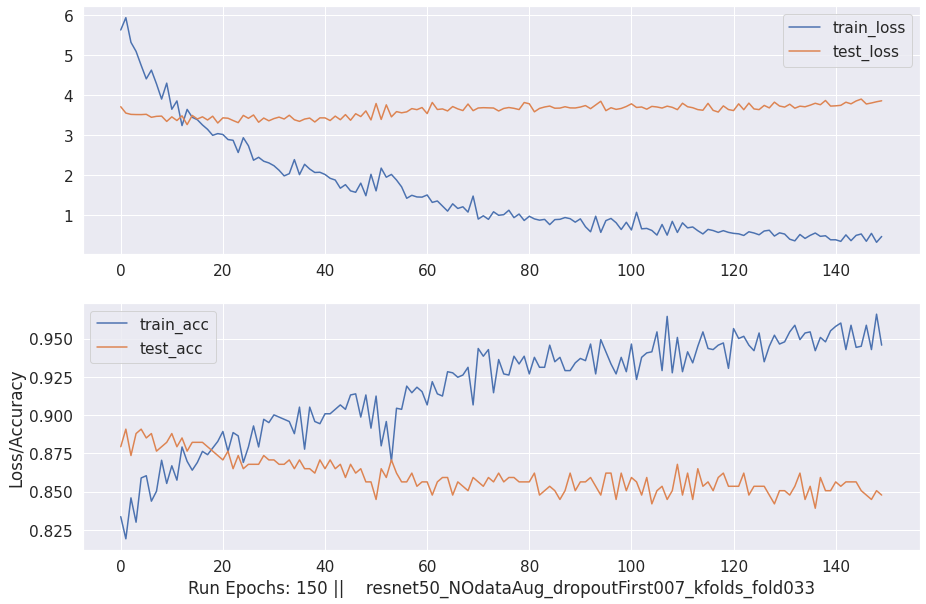

3/3 [==============================] - 1s 229ms/step - loss: 3.8580 - accuracy: 0.8477
              precision    recall  f1-score   support

     Bedroom       0.88      0.92      0.90        79
    Bathroom       0.95      0.88      0.92        43
     Dinning       0.86      0.78      0.81        85
  Livingroom       0.83      0.80      0.81        88
     Kitchen       0.75      0.91      0.82        53

    accuracy                           0.85       348
   macro avg       0.85      0.86      0.85       348
weighted avg       0.85      0.85      0.85       348



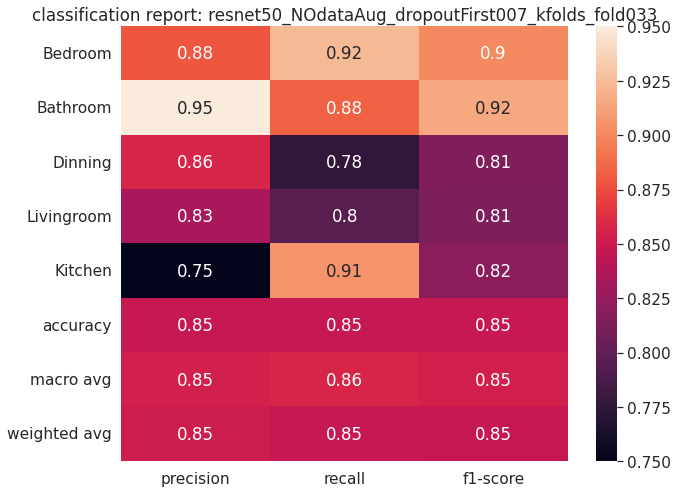

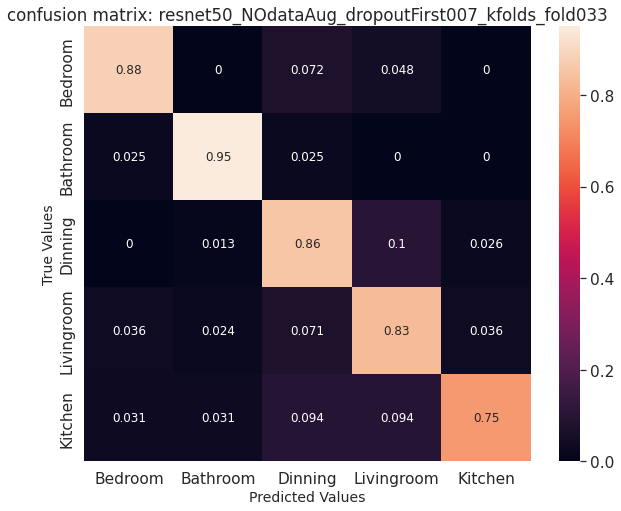

In [12]:
for f in os.listdir(input):
  print("\n ================================",
        "\n FOLDER : ",f)
  print("train dataset")
  train_path = input+f+"/"+'train_ds/'
  train_ds = image_dataset_from_directory(
      train_path,
      class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
      seed=None,
      validation_split=None, 
      subset=None,
      image_size= image_size,
      batch_size= batch_size,
      color_mode='rgb',
      shuffle=False 
  )

  print("\n test dataset")
  test_path = input+f+"/"+"test_ds"
  test_ds = image_dataset_from_directory(
    test_path,
    class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
    seed=None,
    validation_split=None, 
    subset=None,
    image_size= image_size,
    batch_size= batch_size,
    color_mode='rgb',
    shuffle=False 
  )
  
  class_names = train_ds.class_names
  print(class_names)

  # checking numbers
  paths = ['train_ds/', 'test_ds/','val_ds/']
  for p in paths:
      for dir,subdir,files in os.walk(input+f+"/"+p):
          print(dir,' => ', p, str(len(files)))

  # calling model
  model_name, nn = list(models_dict.items())[0]
  print("\n", model_name)
  nn.summary()

  nn.compile( optimizer = opt, #"adam", 
                loss=SparseCategoricalCrossentropy(from_logits=True) ,#'categorical_crossentropy', 
                metrics=['accuracy'] # "recall"
                )

  history = nn.fit(
        train_ds,
        validation_data=test_ds,
        epochs=epochs,
        #callbacks = callbacks # <=== REMOVE CALLBACK for full results
        )
  
  number_of_epochs_it_ran = len(history.history['loss']) 
  print("run epochs: ",number_of_epochs_it_ran)
  name = model_name+"_kfolds_"+f
  #models_dict[m].save(output_folder+name+".h5")

  # saving model accuracy/loss graph
  plotting_model(history,number_of_epochs_it_ran, name, output_folder+name+"-loss_accuracy.png") 
  
  # saving model metrics to json
  evaluation = nn.evaluate(test_ds, batch_size=batch_size, return_dict=True)
  model_evaluation(evaluation, output_folder, name)

  # get inferences
  y_pred_float = nn.predict(test_ds)
  y_pred = np.argmax(y_pred_float, axis=1)

  # get real labels
  y_target = tf.concat([y for x, y in test_ds], axis=0) 

  # classification and confusion matrix reports
  classification_report_pic(y_pred, y_target,  class_names, output_folder, name)
  confusion_matrix_report(y_pred, y_target, class_names, output_folder, name)
  